# Pipeline: Regression Models

## 1. Introduction

Ten years' worth of Infosys' Adjusted Close price data will be used to see if it possible to forecast out 'n' days in the future. Fourteen models will be compared to see whether Gradient-Descent Based, Distance-Based or Tree-Based algorithms perform best.

After a spot check of the models the best performing will be selected and Grid Search cross validation will then be used to find the best parameters for tuning the models, and visualising the results.




## 2. Install/import libraries

In [ ]:
!pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## 3. Import data
Ten years of AstraZeneca stock data will be downloaded from Yahoo! Finance using the yfinance API.

In [ ]:
infy_df = yf.download("INFY.NS", start="2010-01-01", end="2020-01-01")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

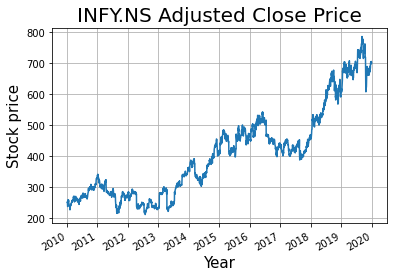

In [5]:
# Plot Adjusted Close price

infy_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('INFY.NS Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [6]:
# Create Dataframe for Adjusted Close prices

infy_adj = infy_df[['Adj Close']]
infy_adj 

,Adj Close
Date,
2010-01-04,252.16
2010-01-05,253.01
2010-01-06,249.31
2010-01-07,243.71
2010-01-08,237.84
...,...
2019-12-24,702.00
2019-12-26,697.74
2019-12-27,705.39


## 4. Feature engineering
The Adjusted Close price will be shifted 'n' days in the future to create a column of prices for prediction.

In [7]:
# A variable for predicting 'n' days into the future

forecast_out = 30

# Create column for target variable shifted 'n' days up
infy_adj['Prediction'] = infy_adj[['Adj Close']].shift(-forecast_out)

infy_adj

,Adj Close,Prediction
Date,,
2010-01-04,252.16,243.09
2010-01-05,253.01,244.54
2010-01-06,249.31,244.42
2010-01-07,243.71,247.89
2010-01-08,237.84,249.14
...,...,...
2019-12-24,702.00,NaN
2019-12-26,697.74,NaN
2019-12-27,705.39,NaN


## 5. Splitting the data

The last 'n' rows will be removed as these rows are NaNs in the Prediction column (y variable). 

In [8]:
X = np.array(infy_adj.drop(['Prediction'], 1))
# Remove last 'n' rows
X = X[:-forecast_out]

print(X)

[[252.16]
 [253.01]
 [249.31]
 ...
 [675.1 ]
 [673.76]
 [675.  ]]


In [9]:
y = np.array(infy_adj['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

[243.09 244.54 244.42 ... 705.39 701.52 699.84]


The data will be split into training and test sets.

In [10]:
train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1702, 1)
(1702,)
(730, 1)
(730,)


In [12]:
print(X_train)
print(y_train)

[[252.16]
 [253.01]
 [249.31]
 ...
 [427.44]
 [428.42]
 [425.3 ]]
[243.09 244.54 244.42 ... 425.14 424.31 424.4 ]


The last 'n' days of the Adjusted Close price will be saved as an array.

In [13]:
X_forecast = np.array(infy_adj.drop(['Prediction'],1))[-forecast_out:]
print(X_forecast)

[[682.33]
 [682.47]
 [682.71]
 [663.52]
 [668.21]
 [661.03]
 [665.96]
 [671.8 ]
 [666.53]
 [663.04]
 [668.45]
 [678.5 ]
 [684.24]
 [684.48]
 [686.54]
 [683.95]
 [690.18]
 [672.04]
 [680.84]
 [683.43]
 [698.46]
 [701.09]
 [699.56]
 [700.23]
 [704.49]
 [702.  ]
 [697.74]
 [705.39]
 [701.52]
 [699.84]]


## 6. Evaluate algorithms

A dictionary of models will be created to spot check using default parameters, and select the best performing ones for tuning.

In [14]:
models = {}
models["Linear"] = LinearRegression()
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["ElasticNet"] = ElasticNet()
models["KNN"] = KNeighborsRegressor()
models["DecisionTree"] = DecisionTreeRegressor()
models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
models["AdaBoost"] = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"] = RandomForestRegressor()
models["ExtraTrees"]= ExtraTreesRegressor()
models["BaggingRegressor"] = BaggingRegressor()
models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')

###  Spot check algorithms



To avoid look-ahead bias we will use sklearn's TimeSeriesSplit class so that models are not trained on data they have already seen. 



In [16]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))

Linear: -0.348395, (0.614656)
Lasso: -0.349462, (0.617823)
Ridge: -0.348393, (0.614658)
ElasticNet: -0.349122, (0.617102)
KNN: -0.859663, (1.132002)
DecisionTree: -1.205143, (1.05441)
SVR: -2.23221, (3.62878)
AdaBoost: -0.747362, (1.149302)
GradientBoost: -0.868677, (1.092444)
RandomForest: -0.982206, (1.114191)
ExtraTrees: -1.079983, (1.06995)
BaggingRegressor: -0.98189, (1.110642)
XGBRegressor: -0.840399, (1.098922)
MLPRegressor: -0.331898, (0.614726)


### Boxplot to compare regression models

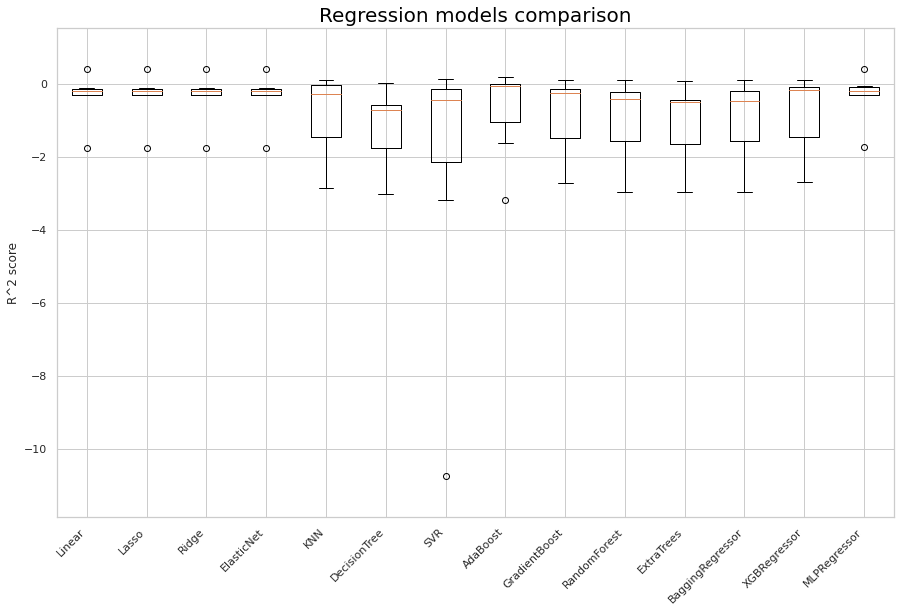

In [17]:
# Compare algorithms  

def box_compare():
  sns.set(rc={'figure.figsize':(15, 9)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()

The performance scores and box plots show that the linear models and the neural network perform the best. We will select Linear Regression and the MLP Regressor. Both are Gradient-Descent based models, although one is linear and the other non-linear.

## 7. Modelling

We will create, train, test and tune Linear Regression and MLP Regressor models.

### 7.1 Create, train and predict on Linear Regression model

We will look at the Linear Regression model first. It adopts a linear approach to modelling the relationship between a dependent variable and independent variable(s), and is also the simplest form of machine learning.









In [18]:
# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
# Make predictions using the model
predictions = lr.predict(X_test)

### Print performance metrics
The performance metric R<sup>2</sup>, or the coefficient of determination, tells us how much variance in the target variable is explained by our model. Values can range from 0 to 1. In general higher values are better, indicating that a model is highly predictive.

In [20]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

Coefficients:  [0.94764159]
RMSE: 43.008
R^2 score: 0.862


The R<sup>2</sup> score tells us that 86% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

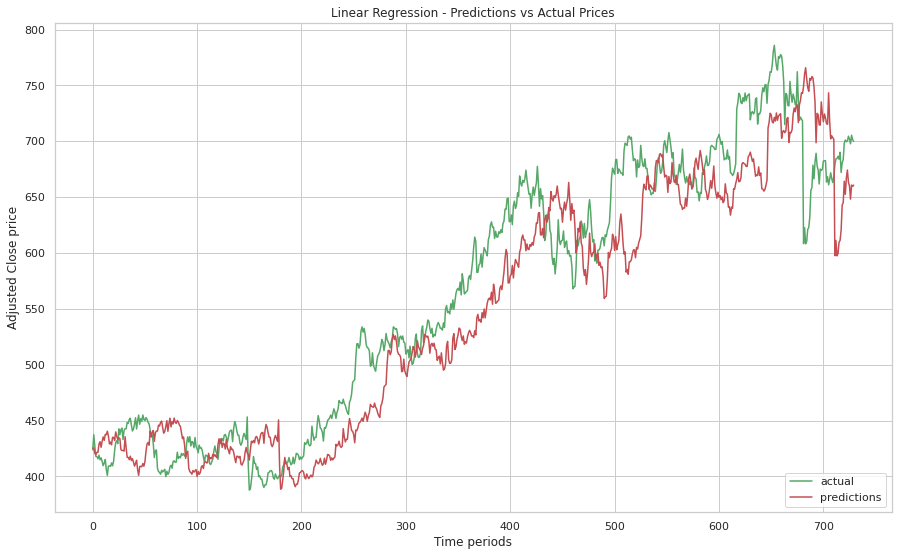

In [21]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [22]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,423.77,425.324874
1,437.30,425.343827
2,426.70,420.747765
3,417.89,419.563213
4,417.78,421.572214


### Scatterplot

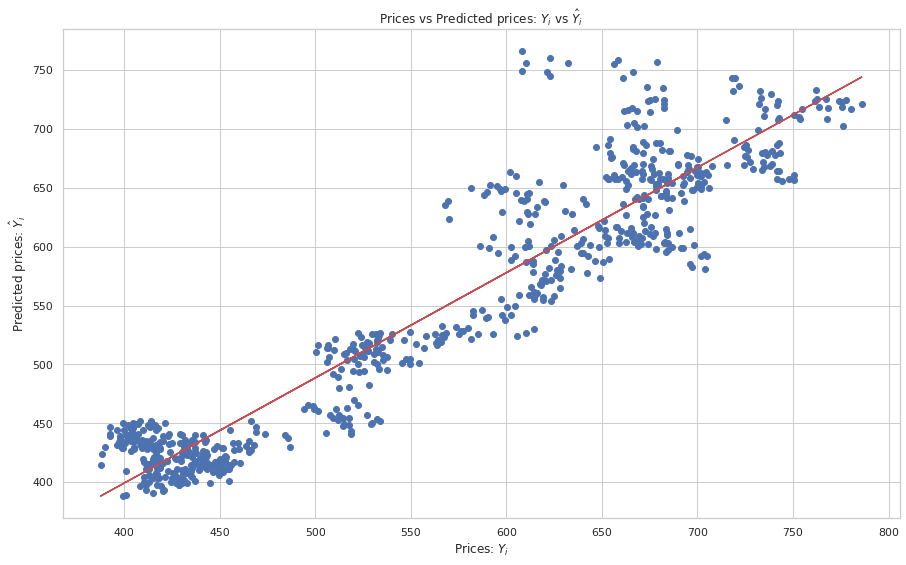

In [23]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [24]:
# Predicted prices

lr_prediction = lr.predict(X_forecast)
print(lr_prediction)

[667.67473486 667.80740469 668.03483867 649.84959653 654.29403559
 647.48996897 652.16184201 657.69606891 652.70199772 649.39472857
 654.52146958 664.04526757 669.4847303  669.71216428 671.66430596
 669.20991424 675.11372135 657.92350289 666.26274889 668.71714061
 682.96019373 685.45249111 684.00259948 684.63751935 688.67447252
 686.31484496 682.27789178 689.52734996 685.859977   684.26793912]


In [25]:
# Actual prices

X_forecast

array([[682.33],
       [682.47],
       [682.71],
       [663.52],
       [668.21],
       [661.03],
       [665.96],
       [671.8 ],
       [666.53],
       [663.04],
       [668.45],
       [678.5 ],
       [684.24],
       [684.48],
       [686.54],
       [683.95],
       [690.18],
       [672.04],
       [680.84],
       [683.43],
       [698.46],
       [701.09],
       [699.56],
       [700.23],
       [704.49],
       [702.  ],
       [697.74],
       [705.39],
       [701.52],
       [699.84]])

### Print performance metrics

In [26]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, lr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, lr_prediction), 3)))

Coefficients:  [0.94764159]
RMSE: 14.779
R^2 score: -0.121


### Visualise predicted vs actual prices





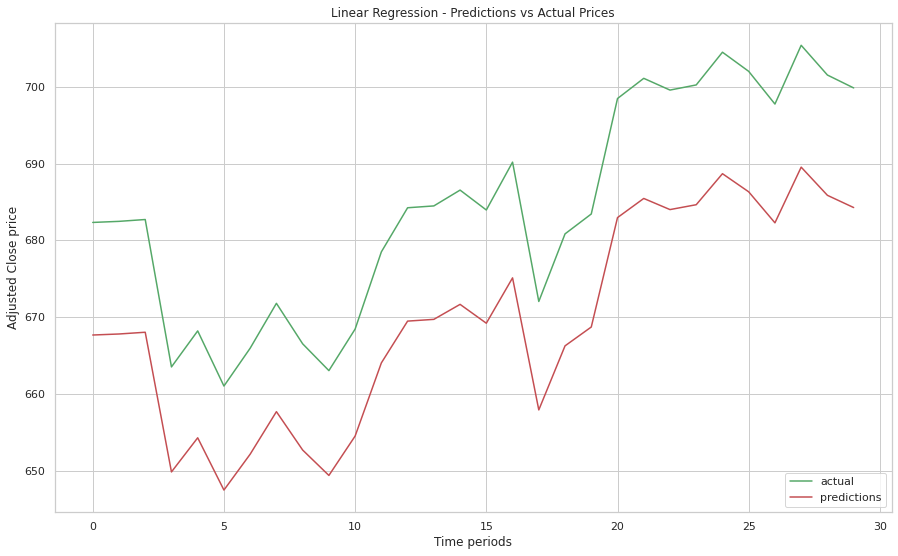

In [27]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [28]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)
X_forecast 

array([682.33, 682.47, 682.71, 663.52, 668.21, 661.03, 665.96, 671.8 ,
       666.53, 663.04, 668.45, 678.5 , 684.24, 684.48, 686.54, 683.95,
       690.18, 672.04, 680.84, 683.43, 698.46, 701.09, 699.56, 700.23,
       704.49, 702.  , 697.74, 705.39, 701.52, 699.84])

In [29]:
pd.DataFrame({"Actual": X_forecast, "Predict": lr_prediction}).head()

,Actual,Predict
0,682.33,667.674735
1,682.47,667.807405
2,682.71,668.034839
3,663.52,649.849597
4,668.21,654.294036


### Grid Search to find optimum parameters

In [30]:
# Create dictionary of parameters
parameters = {'normalize': [True, False], 'fit_intercept': [True, False],
         'n_jobs': [None, -1]}

In [31]:
# Grid search to find best parameters
gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))

Best: -0.19888360884302006 using {'fit_intercept': False, 'n_jobs': None, 'normalize': True}


In [32]:
# All of the best parameters for the optimal model

best_model_lr = grid_result_lr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_lr}")

Best model has the following hyperparameters: LinearRegression(fit_intercept=False, normalize=True)


### Create, train and test tuned model

In [33]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[682.33],
       [682.47],
       [682.71],
       [663.52],
       [668.21],
       [661.03],
       [665.96],
       [671.8 ],
       [666.53],
       [663.04],
       [668.45],
       [678.5 ],
       [684.24],
       [684.48],
       [686.54],
       [683.95],
       [690.18],
       [672.04],
       [680.84],
       [683.43],
       [698.46],
       [701.09],
       [699.56],
       [700.23],
       [704.49],
       [702.  ],
       [697.74],
       [705.39],
       [701.52],
       [699.84]])

In [57]:
# Create Linear Regression model
lr = LinearRegression(fit_intercept=False, normalize=True)

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the model
predictions = lr.predict(X_forecast)


# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

Coefficients:  [[1.00563165]]
RMSE: 3.855
R^2 score: 0.924


The R<sup>2</sup> score has increased to 92.4%

### Visualise predicted vs actual prices of tuned model

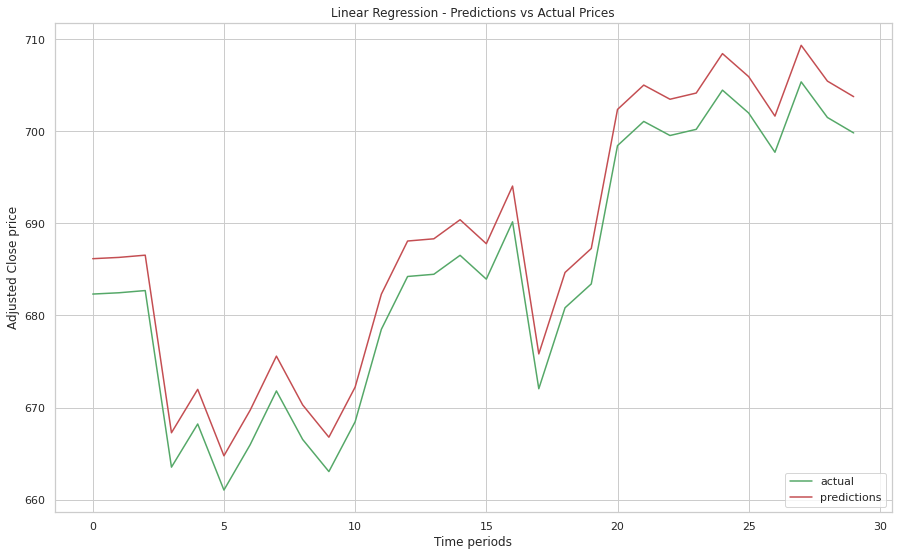

In [35]:
# Plot predictions against actual Adjusted Close prices  

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

We can see that there is now a much better fit.

### 7.2 Create and train MLP Regressor model

The Multi-Layer Perceptron (MLP) Regressor model from scikit-learn is a class of feedforward neural network. We will create and train the model for 500 iterations using the 'lbfgs' solver which is more suited to smaller data sets and can converge faster and perform better than stochastic solvers like 'sgd' and 'adam' which work well on relatively large datasets (with thousands of training samples or more).

In [36]:
# Create an MLP Regressor model  
mlpr = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)
mlpr

MLPRegressor(max_iter=500, solver='lbfgs')

In [37]:
# Make predictions using the model
predictions = mlpr.predict(X_test)

### Print performance metrics

In [38]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

RMSE: 43.008
R^2 score: 0.862


The R<sup>2</sup> score tells us that 86% of the variation in y can be explained by the dependence on X.

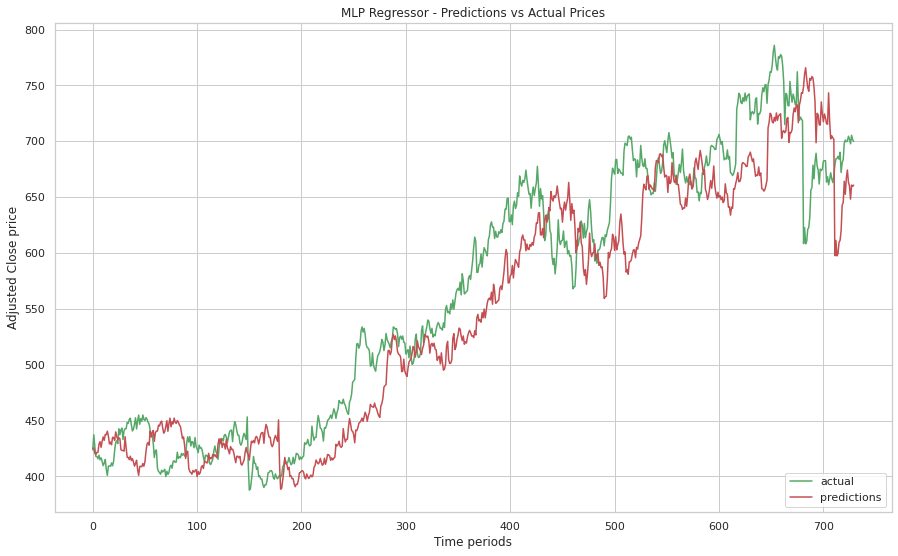

In [39]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [40]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,423.77,425.324863
1,437.30,425.343816
2,426.70,420.747754
3,417.89,419.563201
4,417.78,421.572202


### Scatterplot

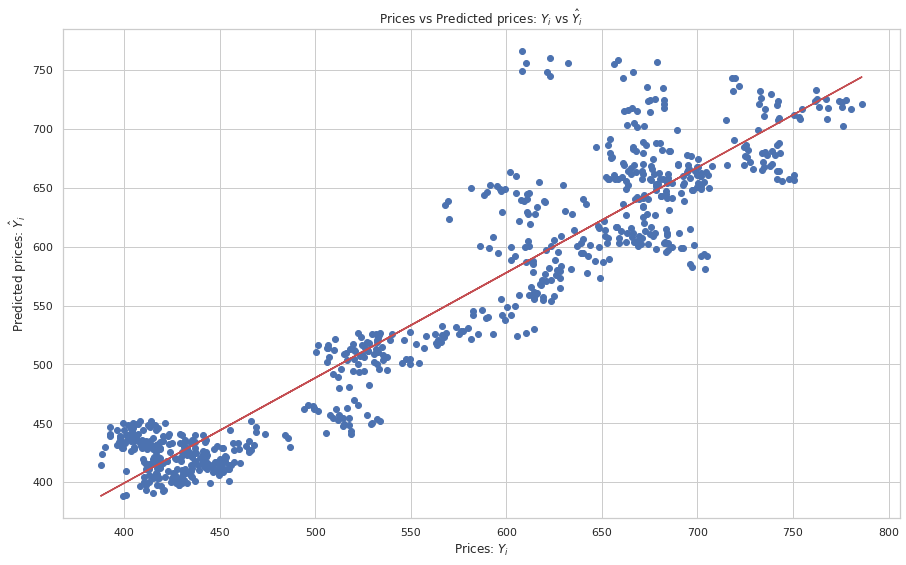

In [41]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [42]:
# Predicted prices

mlpr_prediction = mlpr.predict(X_forecast)
print(mlpr_prediction)

[667.67473716 667.80740699 668.03484098 649.8495978  654.29403712
 647.4899701  652.16184341 657.69607063 652.70199915 649.39472981
 654.52147111 664.04526965 669.4847327  669.71216669 671.66430848
 669.20991662 675.11372407 657.92350462 666.2627511  668.71714297
 682.9601969  685.45249443 684.00260271 684.63752261 688.67447602
 686.31484833 682.27789492 689.52735351 685.85998034 684.26794237]


In [43]:
print(X_forecast)

[[682.33]
 [682.47]
 [682.71]
 [663.52]
 [668.21]
 [661.03]
 [665.96]
 [671.8 ]
 [666.53]
 [663.04]
 [668.45]
 [678.5 ]
 [684.24]
 [684.48]
 [686.54]
 [683.95]
 [690.18]
 [672.04]
 [680.84]
 [683.43]
 [698.46]
 [701.09]
 [699.56]
 [700.23]
 [704.49]
 [702.  ]
 [697.74]
 [705.39]
 [701.52]
 [699.84]]


### Print performance metrics

In [44]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, mlpr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, mlpr_prediction), 3)))

RMSE: 14.779
R^2 score: -0.121


### Visualise predicted vs actual prices

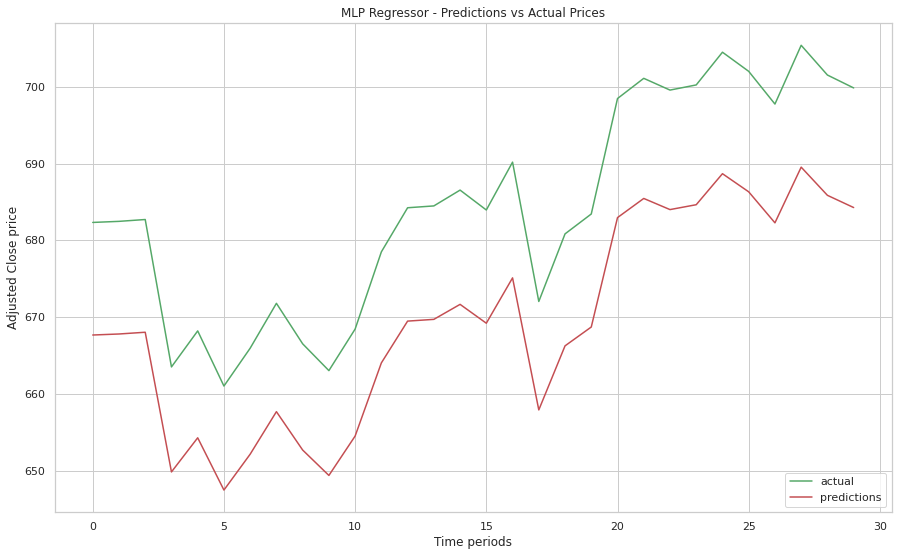

In [45]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, mlpr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, mlpr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

#### Create DataFrame of actual vs predicted prices

In [46]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)

In [47]:
pd.DataFrame({"Actual": X_forecast, "Predict": mlpr_prediction}).head()

,Actual,Predict
0,682.33,667.674737
1,682.47,667.807407
2,682.71,668.034841
3,663.52,649.849598
4,668.21,654.294037


### Feature scaling
Multi-layer Perceptron is sensitive to feature scaling. We will normalise the training data before model fitting by converting values to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance. This is useful for optimisation algorithms and used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs, like regression and neural networks.

In [48]:
# Reshape data as this needs to be 2D
y_train = y_train.reshape(-1, 1)

In [49]:
# Normalise data to improve convergence

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.transform(y_train)
X_test_norm = scaler.transform(X_test)

### Grid Search to find optimum parameters

In [50]:
# Create model

mlpr = MLPRegressor(max_iter=500)

In [51]:
# Create dictionary of parameters to iterate over

parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "solver": ["lbfgs", "sgd", "adam"], 
              "alpha": [0.0001, 0.05], 
              "learning_rate": ['constant','adaptive']}

In [52]:
# Grid search to find best parameters

gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_mlpr = gridsearchcv_mlpr.fit(X_train_norm, y_train_norm)
print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))

Best: -0.19872464856684344 using {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [53]:
# All of the best parameters for the optimal model  

best_model_mlpr = grid_result_mlpr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_mlpr}")

Best model has the following hyperparameters: MLPRegressor(alpha=0.05, hidden_layer_sizes=(50, 50, 50), max_iter=500,
             solver='lbfgs')


### Create, train and test tuned model

In [54]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[682.33],
       [682.47],
       [682.71],
       [663.52],
       [668.21],
       [661.03],
       [665.96],
       [671.8 ],
       [666.53],
       [663.04],
       [668.45],
       [678.5 ],
       [684.24],
       [684.48],
       [686.54],
       [683.95],
       [690.18],
       [672.04],
       [680.84],
       [683.43],
       [698.46],
       [701.09],
       [699.56],
       [700.23],
       [704.49],
       [702.  ],
       [697.74],
       [705.39],
       [701.52],
       [699.84]])

In [59]:
# Create MLP Regression model  
mlpr = MLPRegressor(alpha=0.05, hidden_layer_sizes=(50, 50, 50), max_iter=500,
             solver='lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)

# Make predictions using the model
predictions = mlpr.predict(X_forecast)

# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

RMSE: 14.893
R^2 score: -0.139


### Visualise predicted vs actual prices of tuned model

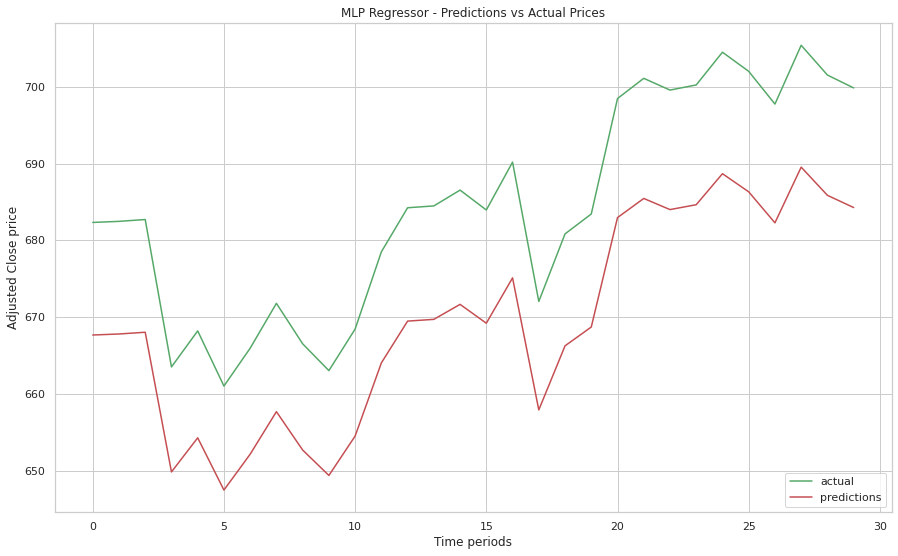

In [56]:
# Plot predictions against actual Adjusted Close prices

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()